# Cross Validation for Regression Models
DSO 530 Spring 2024 \
Group 49: Jessica Bratahani, Pin Hsuan Chang, Suhan Ho, Sheena Huang, Yunchi Lee

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Load the training dataset and scale the variables using StandardScaler()

In [2]:
df_train=pd.read_csv('option_train.csv',index_col=0)

#Drop Duplicates if Any:
df_train = df_train.dropna()

X_train = df_train[['S','K','tau','r']]
y_train = df_train['Value']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train[['S','K','tau','r']])

## List regression models to be compared using CV

In [3]:
regression_models= [LinearRegression(), 
         Ridge(), Lasso(),
         DecisionTreeRegressor(random_state = 0), 
         RandomForestRegressor(random_state=0, oob_score=True),
                   KNeighborsRegressor(n_neighbors=5)]


In [4]:
# Define function to perform k-folds CV
# we can specify regressor to use, number of kfolds, x and y training data
def kfolds_cv_regression(regressor, kfolds, x_train, y_train):
    kfolds_regression = KFold(n_splits = kfolds, random_state = 1, shuffle = True)
    r2_model_1_cv = cross_val_score(regressor, x_train, y_train, cv=kfolds_regression)
    #print("r squared of ",kfolds,"-folds:",r2_model_1_cv,"(mean r squared:",np.mean(r2_model_1_cv),")")
    neg_mse_model_1_cv = cross_val_score(regressor, x_train, y_train, cv=kfolds_regression,scoring = 'neg_mean_squared_error')
    #print("mean_squared_error of ",kfolds,"-folds:",-neg_mse_model_1_cv,"(mean MSE:",-np.mean(neg_mse_model_1_cv),")")
    return np.mean(r2_model_1_cv), -np.mean(neg_mse_model_1_cv)

# K-Fold Cross Validation on different regression models, compared on Mean R Squared and Mean MSE

In [11]:
results = []
for regressor in regression_models:
    for KFolds in [5,10,15]:
        model_name=type(regressor).__name__
        
        # Perform cross-validation and get scores
        mean_r2, mean_mse=kfolds_cv_regression(regressor, KFolds, X_train_scaled, y_train)
        results.append({'Model': model_name, 'KFolds':KFolds,'Mean R Squared': mean_r2, 'Mean MSE': mean_mse})

# Print the results DataFrame
df_results = pd.DataFrame(results)

In [12]:
df_results.sort_values(['KFolds','Mean R Squared'])

,Model,KFolds,Mean R Squared,Mean MSE
6,Lasso,5,0.924447,1182.778282
0,LinearRegression,5,0.924657,1179.476688
3,Ridge,5,0.924658,1179.470433
15,KNeighborsRegressor,5,0.990365,150.120516
9,DecisionTreeRegressor,5,0.992236,120.967048
12,RandomForestRegressor,5,0.996515,54.397492
7,Lasso,10,0.924599,1183.263556
1,LinearRegression,10,0.924821,1180.050385
4,Ridge,10,0.924821,1180.041713
16,KNeighborsRegressor,10,0.991001,140.809494


Based on K-Fold CV results, Random Forest Regressor resulted best in terms of Mean R-Squared and MSE, therefore we choose Random Forest Regressor as our winning model.
Thus we would like to try Hyperparameter Tuning to further improve the Random Forest regressor.

## Random Forest Regressor Hyperparameter Tuning

In [15]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(random_state=0, oob_score=True)

In [16]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(regressor.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


### GridSearchCV for Hyperparameter Tuning

In [17]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20, 30],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2,4,6],
    'n_estimators': [1000, 1100, 1200, 1500]
}
# Create a based model
regressor = RandomForestRegressor(random_state=0, oob_score=True)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

In [18]:
# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)
# Get the model with best hyperparameters
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [19]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(max_depth=30, max_features=3, min_samples_leaf=2,
                      n_estimators=1000, oob_score=True, random_state=0)

Run k-fold CV on BASE Random Forest Regressor

In [20]:
results = []
for regressor in [RandomForestRegressor(random_state=0, oob_score=True)]:
    for KFolds in [5,10,15]:
        model_name=type(regressor).__name__
        
        # Perform cross-validation and get scores
        mean_r2, mean_mse=kfolds_cv_regression(regressor, KFolds, X_train_scaled, y_train)
        results.append({'Model': model_name, 'KFolds':KFolds,'Mean R Squared': mean_r2, 'Mean MSE': mean_mse})

# Print the results DataFrame
df_results = pd.DataFrame(results)
df_results

,Model,KFolds,Mean R Squared,Mean MSE
0,RandomForestRegressor,5,0.996515,54.397492
1,RandomForestRegressor,10,0.996776,50.426409
2,RandomForestRegressor,15,0.996806,49.589119


Run k-fold CV on best model from GridSearchCV Random Forest Regressor

In [21]:
results = []
#for regressor in [RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=3,
 #                     min_samples_split=8, n_estimators=1000, oob_score=True,
  #                    random_state=0)]:
for regressor in [RandomForestRegressor(max_depth=30, max_features=3, min_samples_leaf=2,
                      min_samples_split=2, n_estimators=1000, oob_score=True,
                      random_state=0)]:
    for KFolds in [5,10,15]:
        model_name=type(regressor).__name__
        
        # Perform cross-validation and get scores
        mean_r2, mean_mse=kfolds_cv_regression(regressor, KFolds, X_train_scaled, y_train)
        results.append({'Model': model_name, 'KFolds':KFolds,'Mean R Squared': mean_r2, 'Mean MSE': mean_mse})

# Print the results DataFrame
df_results = pd.DataFrame(results)
df_results



,Model,KFolds,Mean R Squared,Mean MSE
0,RandomForestRegressor,5,0.996317,57.472959
1,RandomForestRegressor,10,0.996614,52.862028
2,RandomForestRegressor,15,0.996610,52.606638


After Hyperparameter Tuning, our Mean R-Squared and MSE did not improve, therefore we chose to stick to our base RandomForest regressor.

## Feature Importance on Random Forest Model
After choosing the best Model, we also explored which features are more important

In [22]:
regressor = RandomForestRegressor(random_state=0, oob_score=True)
regressor.fit(X_train_scaled, y_train)
global_importances_random = pd.Series(regressor.feature_importances_, index=list(X_train.columns))

In [23]:
regressor.feature_importances_

array([0.07348851, 0.87014665, 0.0438318 , 0.01253305])

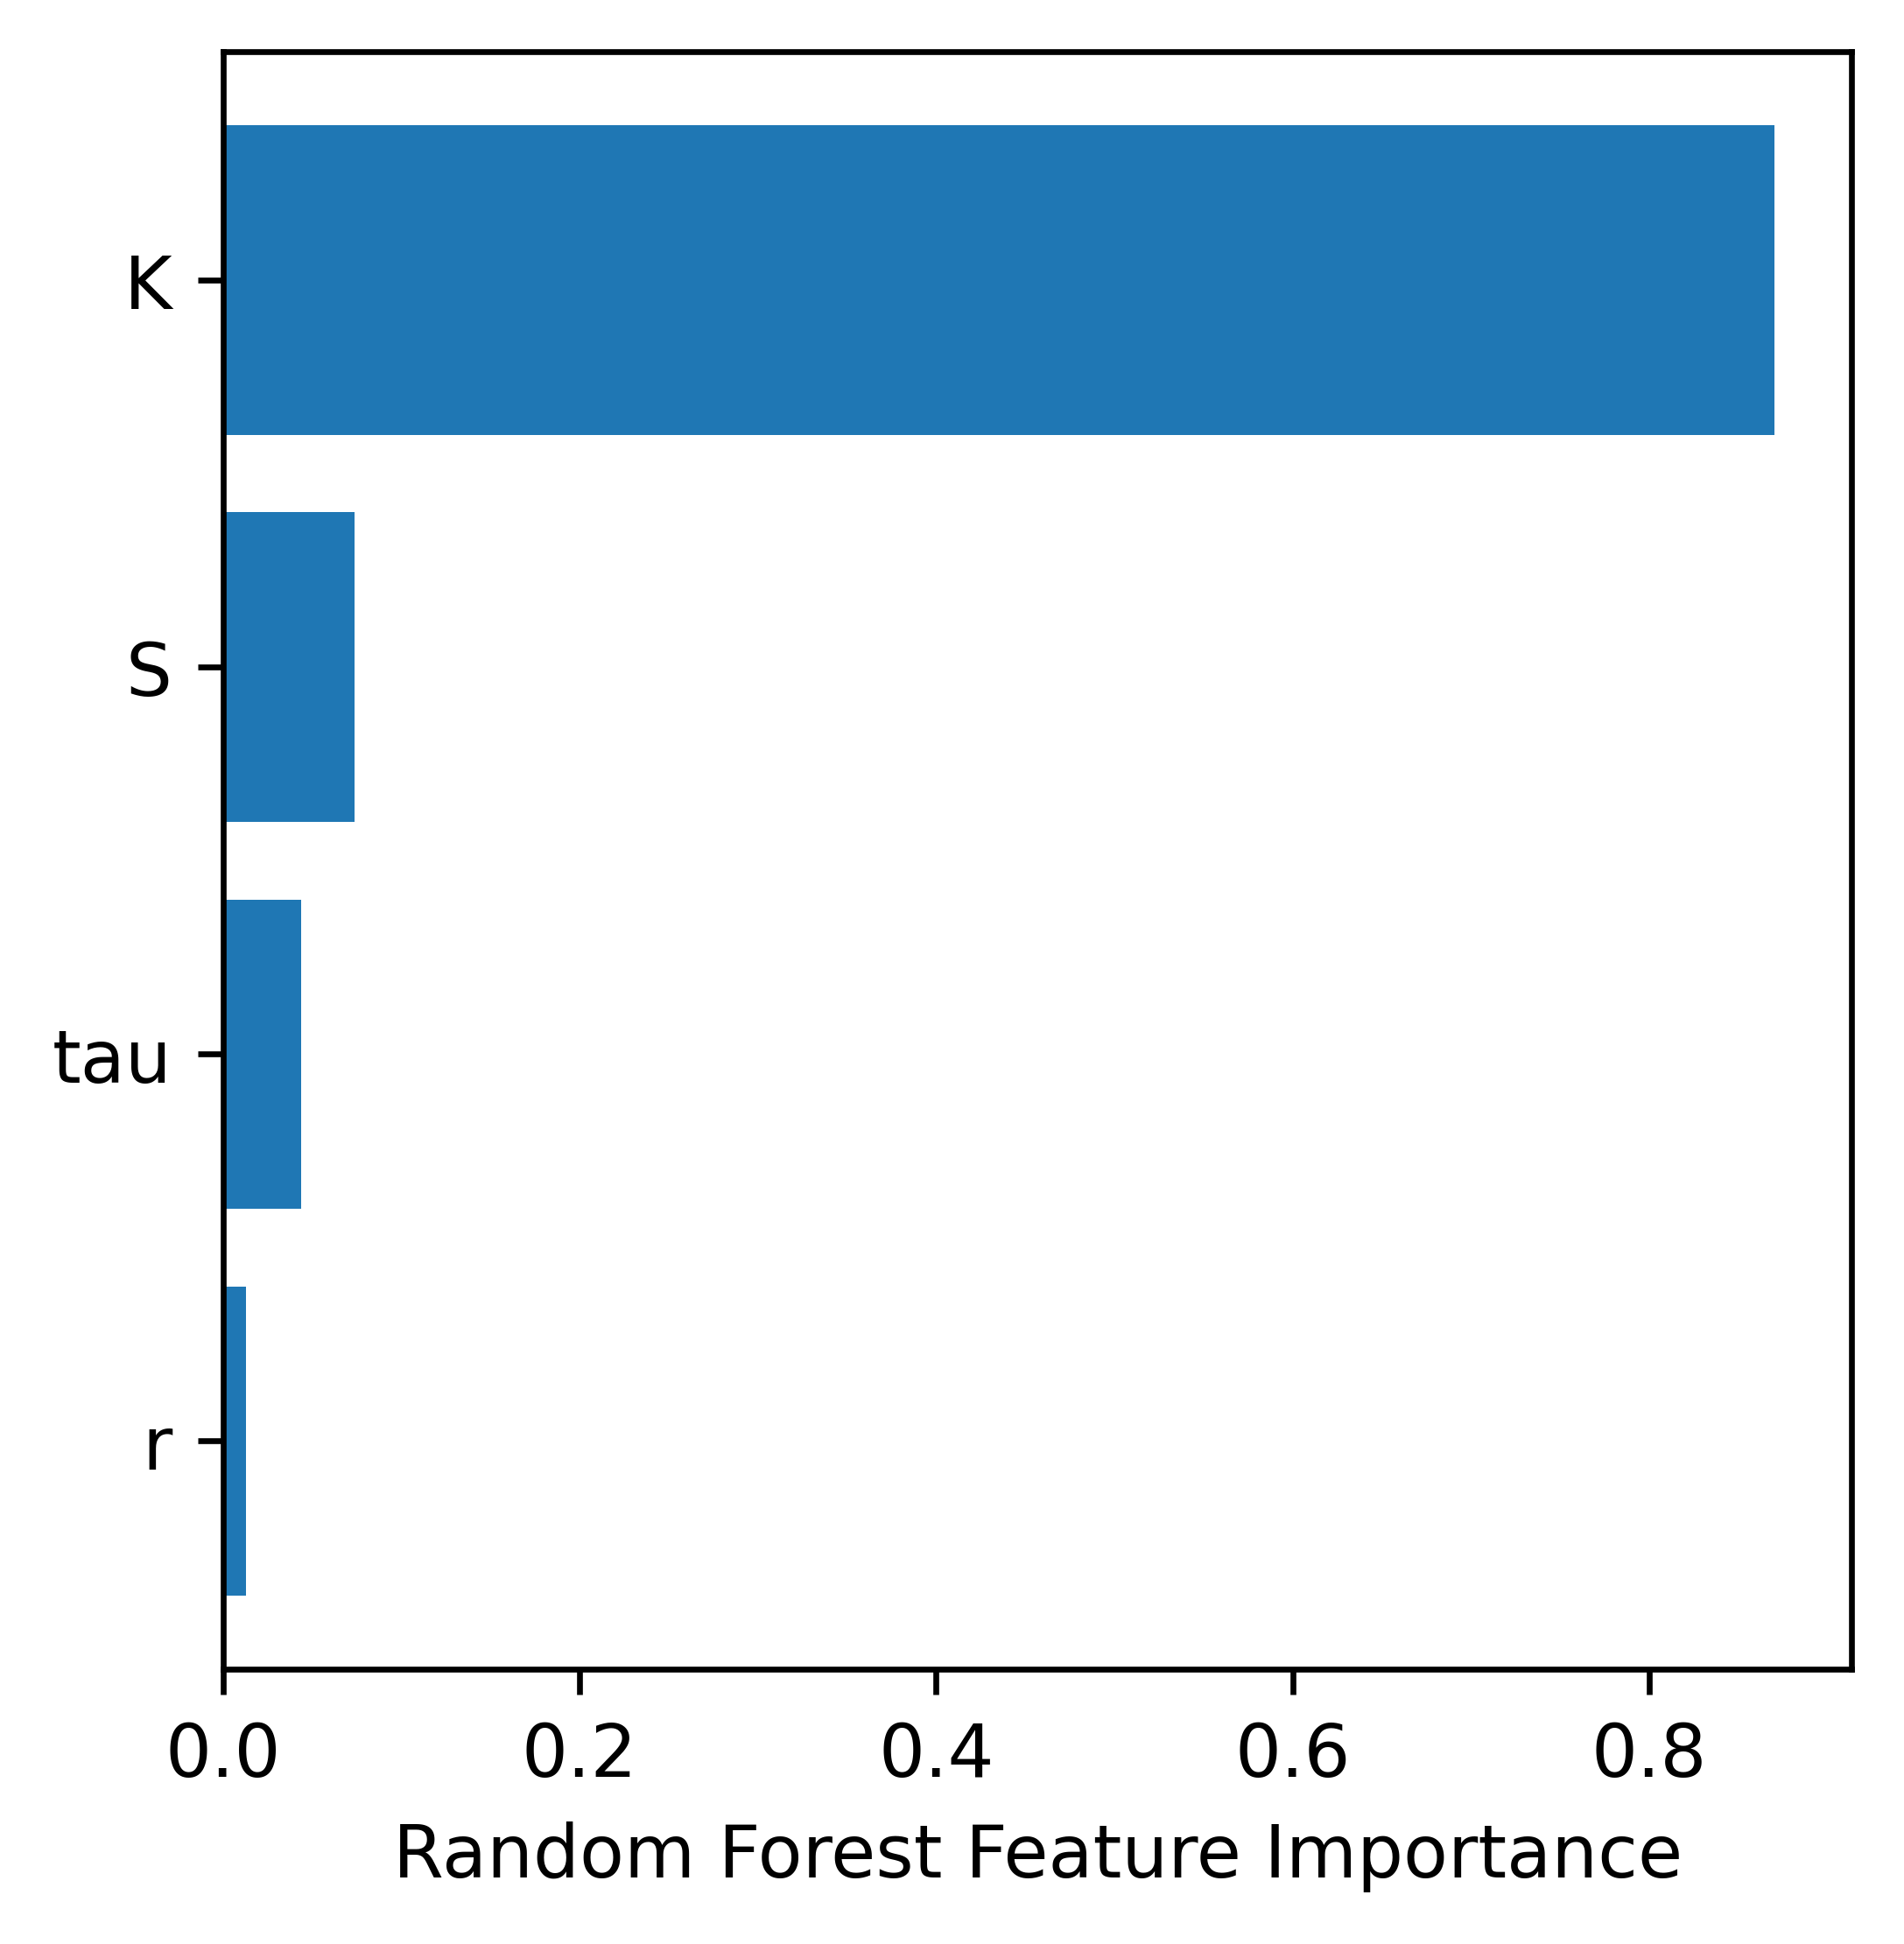

In [24]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=600) 
sorted_idx = regressor.feature_importances_.argsort()[-10:] ## remove [-10:] to␣get a plot for all features 
plt.barh(X_train.columns[sorted_idx], regressor.feature_importances_[sorted_idx]) 
plt.xlabel("Random Forest Feature Importance")
plt.savefig('plot.png')